In [1]:
from warnings import filterwarnings
filterwarnings("ignore")

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.feature_selection import SequentialFeatureSelector, RFE
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score

In [2]:
outliers_df = pd.read_csv('outliers-data.csv')
outliers_df.drop(columns=["Unnamed: 0"],inplace=True)

In [3]:
outliers_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7757 entries, 0 to 7756
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   bed             7757 non-null   float64
 1   bath            7757 non-null   float64
 2   acre_lot        7757 non-null   float64
 3   zip_code        7757 non-null   float64
 4   house_size      7757 non-null   float64
 5   prev_sold_date  7757 non-null   object 
 6   price           7757 non-null   float64
dtypes: float64(6), object(1)
memory usage: 424.3+ KB


In [4]:
outliers_df["prev_sold_year"] = pd.to_datetime(outliers_df["prev_sold_date"], format='%Y-%m-%d').dt.year
outliers_df.drop(columns=["prev_sold_date"],inplace=True)
outliers_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7757 entries, 0 to 7756
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   bed             7757 non-null   float64
 1   bath            7757 non-null   float64
 2   acre_lot        7757 non-null   float64
 3   zip_code        7757 non-null   float64
 4   house_size      7757 non-null   float64
 5   price           7757 non-null   float64
 6   prev_sold_year  7757 non-null   int64  
dtypes: float64(6), int64(1)
memory usage: 424.3 KB


In [5]:
features = ["acre_lot","bed","bath","house_size","prev_sold_year","zip_code"]
num_features_to_select = len(features)-1
random_state_value = 42

In [6]:
#"bed","bath","acre_lot","zip_code","house_size","prev_sold_year"
X = outliers_df[features]
y = outliers_df["price"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=random_state_value)

In [7]:
results_dict = {"model":[], "explained variance score":[],"mae score":[],"mse score":[],"r2 score":[]}
def print_more_stuff(title, y_param, predict_param):
    results_dict["model"].append(title)
    
    evs = "{:.9f}".format(explained_variance_score(y_param,predict_param))
    mae = "{:,.6f}".format(mean_absolute_error(y_param,predict_param))
    mse = "{:,.6f}".format(mean_squared_error(y_param,predict_param))
    r2 = "{:,.6f}".format(r2_score(y_param,predict_param))
    
    results_dict["explained variance score"].append(evs)
    results_dict["mae score"].append(mae)
    results_dict["mse score"].append(mse)
    results_dict["r2 score"].append(r2)    
    
    print(title + " EVS = " + evs)
    print(title + " MSE = " + mse)
    print(title + " MAE = " + mae)
    print(title + " R2 = " + r2)

In [8]:
dtree = DecisionTreeRegressor()
dtree_model = dtree.fit(X_train,y_train)
dtree_predict = dtree_model.predict(X_test)
dtree_mse = mean_squared_error(y_test,dtree_predict)
print_more_stuff("Decision Tree", y_test, dtree_predict)

Decision Tree EVS = 0.447228541
Decision Tree MSE = 110,204,025,645.037933
Decision Tree MAE = 189,530.166810
Decision Tree R2 = 0.447185


In [9]:
dtree_rfe = RFE(DecisionTreeRegressor(), n_features_to_select=num_features_to_select)
dtree_rfe.fit(X, y)
dtree_rfe_selected_features = dtree_rfe.get_support()
print('The selected features are:', list(X.columns[dtree_rfe_selected_features]))

The selected features are: ['acre_lot', 'bath', 'house_size', 'prev_sold_year', 'zip_code']


In [10]:
X_rfe = outliers_df[list(X.columns[dtree_rfe_selected_features])]
y_rfe = outliers_df["price"]
X_rfe_train, X_rfe_test, y_rfe_train, y_rfe_test = train_test_split(X_rfe, y_rfe, test_size=0.3, random_state=random_state_value)

In [11]:
dtree_rfe = DecisionTreeRegressor()
dtree_rfe_model = dtree_rfe.fit(X_rfe_train,y_rfe_train)
dtree_rfe_predict = dtree_rfe_model.predict(X_rfe_test)
dtree_rfe_mse = mean_squared_error(y_rfe_test,dtree_rfe_predict)
print_more_stuff("Recursive Feature Elimination", y_rfe_test, dtree_rfe_predict)

Recursive Feature Elimination EVS = 0.407013060
Recursive Feature Elimination MSE = 118,290,001,662.401306
Recursive Feature Elimination MAE = 197,625.776144
Recursive Feature Elimination R2 = 0.406623


In [12]:
dtree_sfs = SequentialFeatureSelector(DecisionTreeRegressor(), n_features_to_select=num_features_to_select)
dtree_sfs.fit(X, y)
dtree_sfs_selected_features = dtree_sfs.get_support()
print('The selected features are:', list(X.columns[dtree_sfs_selected_features]))

The selected features are: ['bed', 'bath', 'house_size', 'prev_sold_year', 'zip_code']


In [13]:
X_sfs = outliers_df[list(X.columns[dtree_sfs_selected_features])]
y_sfs = outliers_df["price"]
X_sfs_train, X_sfs_test, y_sfs_train, y_sfs_test = train_test_split(X_sfs, y_sfs, test_size=0.3, random_state=random_state_value)

In [14]:
dtree_sfs = DecisionTreeRegressor()
dtree_sfs_model = dtree_sfs.fit(X_sfs_train,y_sfs_train)
dtree_sfs_predict = dtree_sfs_model.predict(X_sfs_test)
dtree_sfs_mse = mean_squared_error(y_sfs_test,dtree_sfs_predict)

print_more_stuff("Sequential Feature Selector", y_sfs_test, dtree_sfs_predict)

Sequential Feature Selector EVS = 0.399944449
Sequential Feature Selector MSE = 119,628,077,434.679474
Sequential Feature Selector MAE = 193,573.015137
Sequential Feature Selector R2 = 0.399911


In [15]:
dtree_predict_df = pd.DataFrame(dtree_predict).reset_index()
dtree_predict_df.rename(columns={0: "prediction"},inplace=True)

dtree_sfs_predict_df = pd.DataFrame(dtree_sfs_predict).reset_index()
dtree_sfs_predict_df.rename(columns={0: "prediction"},inplace=True)

dtree_rfe_predict_df = pd.DataFrame(dtree_rfe_predict).reset_index()
dtree_rfe_predict_df.rename(columns={0: "prediction"},inplace=True)

y_test_df = pd.DataFrame(y_test).reset_index()


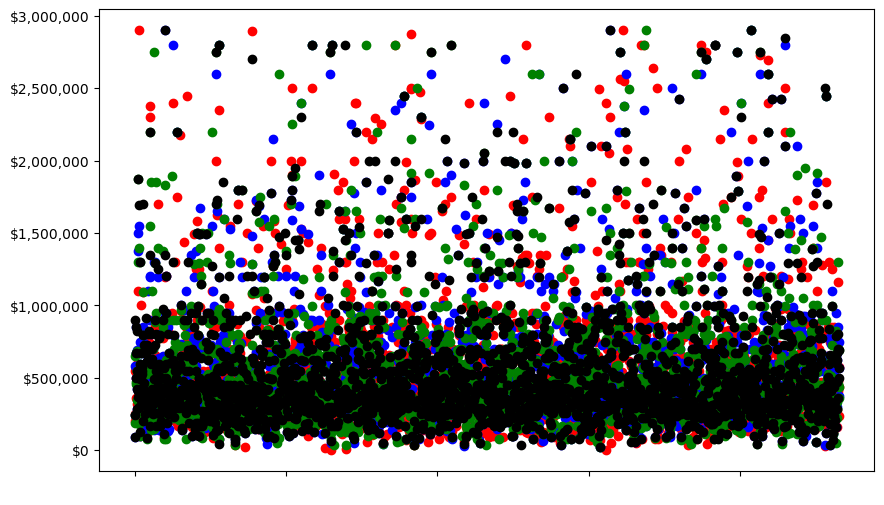

In [16]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.ticklabel_format(style='plain')
ax.yaxis.set_major_formatter('${x:1,.0f}')
ax.xaxis.set_major_formatter(' ')

plt.scatter(y_test_df.index,y_test_df["price"], color="red")
plt.scatter(dtree_rfe_predict_df.index,dtree_rfe_predict_df["prediction"], color="blue")
plt.scatter(dtree_sfs_predict_df.index,dtree_sfs_predict_df["prediction"], color="green")
plt.scatter(dtree_predict_df.index,dtree_predict_df["prediction"], color="black")
plt.show()

In [17]:
model_comparisons = pd.DataFrame(results_dict).set_index('model')
model_comparisons

,explained variance score,mae score,mse score,r2 score
model,,,,
Decision Tree,0.447228541,"189,530.166810","110,204,025,645.037933",0.447185
Recursive Feature Elimination,0.407013060,"197,625.776144","118,290,001,662.401306",0.406623
Sequential Feature Selector,0.399944449,"193,573.015137","119,628,077,434.679474",0.399911
